# String Operations- Which month was the snowiest

## Install

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.2b2 matches the requirement >=0.8.2b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-6", port=9086, reset=True)

Starting pandas-test-domain-6 server on 0.0.0.0:9086


Waiting for server to start Done.


# Data owner: upload dataset

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-6 as <info@openmined.org>


## Load data

By the end of this chapter, we're going to have downloaded all of Canada's weather data for 2012, and saved it to a CSV.

We'll do this by downloading it one month at a time, and then combining all the months together.

Here's the temperature every hour for 2012!

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

In [6]:
from datetime import timedelta
import random
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.service.project.project import Project
from syft.util.util import autocache, PANDAS_DATA

In [7]:
weather_2012_final = pd.read_csv(autocache(f"{PANDAS_DATA}/weather_2012.csv"), index_col='Date/Time', parse_dates=True)

In [8]:
assert len(weather_2012_final) == 8784

<Axes: xlabel='Date/Time'>

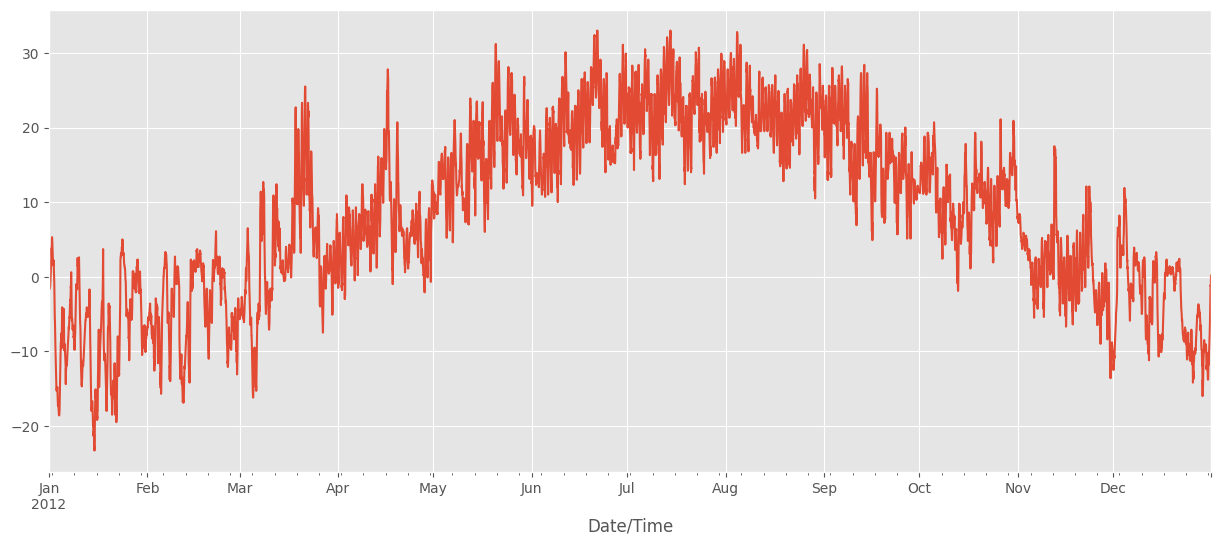

In [9]:
weather_2012_final['Temp (C)'].plot(figsize=(15, 6))

## Create mock data

Instead, we upload our dataset per month as a starting point

In [10]:
weather_types = set(weather_2012_final.Weather.to_list())

In [11]:
def get_mock_date(i):
    return str(parse('Jun 1 2010') + timedelta(days=i))

def get_mock_row(i):
    res = dict()
    for k, function in mock_functions.items():
        res[k] = function()
    return res
    

In [12]:
mock_functions = {
    "Temp (C)": lambda: random.uniform(-10, 40),
    "Dew Point Temp (C)": lambda: random.uniform(-10, 10),
    "Rel Hum (%)": lambda: random.randint(50, 100),
    "Wind Spd (km/h)": lambda: random.randint(1, 30),
    'Visibility (km)': lambda: random.uniform(0.5, 40),
    'Stn Press (kPa)': lambda: random.uniform(50, 100),
    'Weather': lambda: random.choice(list(weather_types))
}

In [13]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(weather_2012_final))],
                    data=[get_mock_row(i) for i in range(len(weather_2012_final))],
                    columns=weather_2012_final.columns)
    


Upload the data

In [14]:
dataset = sy.Dataset(name="test", asset_list=[sy.Asset(name=f"weather", data=weather_2012_final,
                                                       mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

100%|██████████| 1/1 [00:00<00:00,  5.09it/s]

Uploading: weather


<class 'syft.service.response.SyftSuccess'>: Dataset uploaded to 'pandas-test-domain-6'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

In [15]:
weather_2012_final.head()

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


## Create user account

In [16]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")
# todo: give user data scientist role
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-6 as <jane@caltech.edu>


# Data scientist: create syft function

In [17]:
import numpy as np
import pandas as pd

## Summary
By the end of this chapter, we're going to have downloaded all of Canada's weather data for 2012, and saved it to a CSV.

We'll do this by downloading it one month at a time, and then combining all the months together.

## Get mocks

In [18]:
ds = guest_domain_client.datasets[0]

In [19]:
asset = ds.assets[0]

In [20]:
weather_2012 = asset.mock

## String Operations

You'll see that the 'Weather' column has a text description of the weather that was going on each hour. We'll assume it's snowing if the text description contains "Snow".

pandas provides vectorized string functions, to make it easy to operate on columns containing text. There are some great examples in the documentation.

In [21]:
weather_description = weather_2012['Weather']
is_snowing = weather_description.str.contains('Snow')

This gives us a binary vector, which is a bit hard to look at, so we'll plot it.



In [22]:
# Not super useful
is_snowing[:5]

2010-06-01    False
2010-06-02     True
2010-06-03    False
2010-06-04     True
2010-06-05    False
Name: Weather, dtype: bool

<Axes: >

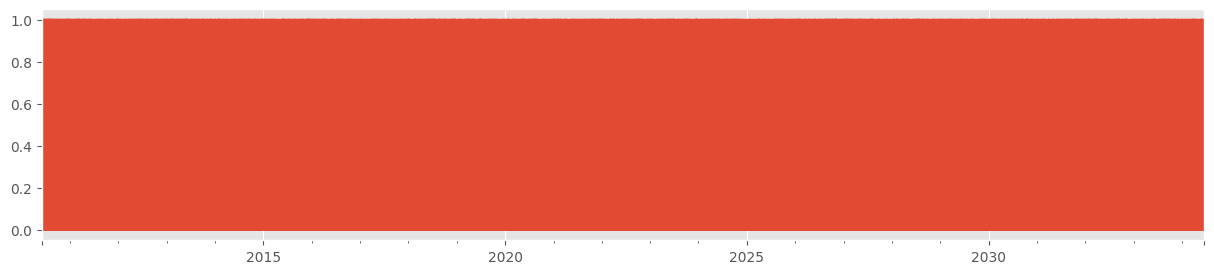

In [23]:
# More useful!
is_snowing=is_snowing.astype(float)
is_snowing.plot()

## Use resampling to find the snowiest month

If we wanted the median temperature each month, we could use the resample() method like this:

In [24]:
weather_2012

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
2010-06-01,15.221185,-7.433316,91,6,38.791129,96.984032,"Thunderstorms,Rain"
2010-06-02,23.849900,8.156957,59,1,15.934509,97.593184,Moderate Snow
2010-06-03,1.697832,-8.388298,87,15,37.486805,51.452045,Thunderstorms
2010-06-04,-2.927046,-1.439246,72,28,7.928811,62.492165,"Rain Showers,Snow Showers"
2010-06-05,23.536630,4.174220,88,10,7.420188,96.232558,Cloudy
...,...,...,...,...,...,...,...
2034-06-14,24.384388,-6.406001,96,14,13.335184,71.609622,"Drizzle,Fog"
2034-06-15,4.353820,6.164121,50,22,12.183355,94.839727,"Snow,Blowing Snow"
2034-06-16,13.571221,9.558830,89,20,4.522365,67.633521,"Thunderstorms,Rain,Fog"
2034-06-17,35.353955,-5.731824,90,24,31.149442,99.685684,"Rain Showers,Snow Showers"


<Axes: >

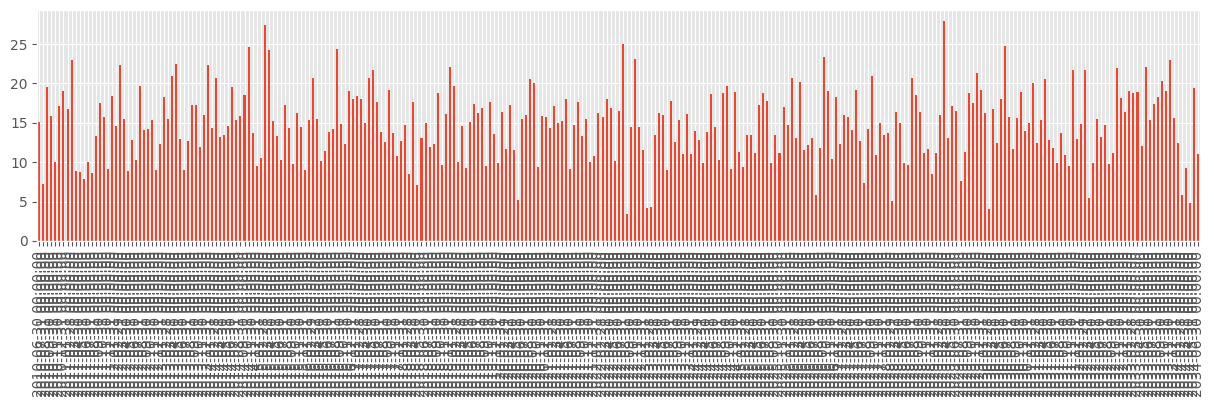

In [25]:
weather_2012['Temp (C)'].resample('M').apply(np.median).plot(kind='bar')

Unsurprisingly, July and August are the warmest.

So we can think of snowiness as being a bunch of 1s and 0s instead of Trues and Falses:

In [26]:
is_snowing.astype(float)[:10]

2010-06-01    0.0
2010-06-02    1.0
2010-06-03    0.0
2010-06-04    1.0
2010-06-05    0.0
2010-06-06    1.0
2010-06-07    0.0
2010-06-08    0.0
2010-06-09    0.0
2010-06-10    1.0
Name: Weather, dtype: float64

and then use resample to find the percentage of time it was snowing each month

In [27]:
is_snowing.astype(float).resample('M').apply(np.mean)

2010-06-30    0.500000
2010-07-31    0.419355
2010-08-31    0.483871
2010-09-30    0.500000
2010-10-31    0.516129
                ...   
2034-02-28    0.357143
2034-03-31    0.387097
2034-04-30    0.300000
2034-05-31    0.354839
2034-06-30    0.333333
Freq: M, Name: Weather, Length: 289, dtype: float64

<Axes: >

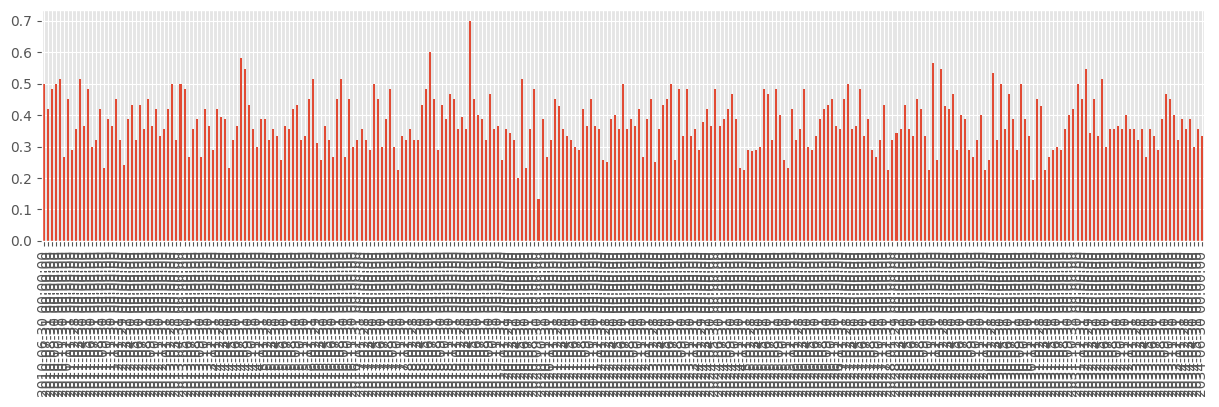

In [28]:
is_snowing.astype(float).resample('M').apply(np.mean).plot(kind='bar')

So now we know! In 2012, December was the snowiest month. Also, this graph suggests something that I feel -- it starts snowing pretty abruptly in November, and then tapers off slowly and takes a long time to stop, with the last snow usually being in April or May.


## Plotting temperature and snowiness stats together

We can also combine these two statistics (temperature, and snowiness) into one dataframe and plot them together:



In [29]:
temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
is_snowing = weather_2012['Weather'].str.contains('Snow')
snowiness = is_snowing.astype(float).resample('M').apply(np.mean)

# Name the columns
temperature.name = "Temperature"
snowiness.name = "Snowiness"

We'll use `concat` again to combine the two statistics into a single dataframe.

In [30]:
stats = pd.concat([temperature, snowiness], axis=1)

In [31]:
stats.columns = ["temperature", "snowiness"]

## Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [32]:
@sy.syft_function(input_policy=sy.ExactMatch(df=ds.assets[0]),
                  output_policy=sy.SingleExecutionExactOutput())
def snow_and_temperature(df):
    import pandas as pd
    import numpy as np
    weather_2012 = df
    weather_description = weather_2012['Weather']
    is_snowing = weather_description.str.contains('Snow')
    
    median_temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    snow_frequency = is_snowing.astype(float).resample('M').apply(np.mean)
    
    temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    is_snowing = weather_2012['Weather'].str.contains('Snow')
    snowiness = is_snowing.astype(float).resample('M').apply(np.mean)

    # Name the columns
    temperature.name = "Temperature"
    snowiness.name = "Snowiness"
    stats = pd.concat([temperature, snowiness], axis=1)
    stats.columns = ["temperature", "snowiness"]
    
    return is_snowing.astype(float), median_temperature, snow_frequency, stats

Syft function 'snow_and_temperature' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


Create and submit project

In [33]:
new_project = sy.Project(
    name="Pandas Chapter 6",
    description="Hi, I would like to get some insights about snow and temperature for 2012",
    members=[guest_domain_client],
)
new_project

syft.service.project.project.ProjectSubmit

In [34]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

syft.service.project.project.Project

In [35]:
project.create_code_request(snow_and_temperature, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Code request for 'snow_and_temperature' successfully added to 'Pandas Chapter 6' Project. To see code requests by a client, run `[your_client].code`

In [36]:
assert len(guest_domain_client.code.get_all())==1

In [37]:
assert len(project.events) == 1

In [38]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute syft_function

In [39]:
from syft import MessageStatus

In [40]:
domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-6 as <info@openmined.org>


# Get messages

In [41]:
messages = domain_client.api.services.messages.get_all_unread()

In [42]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [43]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [44]:
request = project_message.link.events[0].request
func = request.changes[0].link
op = func.output_policy_type

In [45]:
func

```python
class UserCode
    id: str = d1713acda1bd43a59f1f7f5fb387364b
    status.approved: str = False
    service_func_name: str = snow_and_temperature
    code:

@sy.syft_function(input_policy=sy.ExactMatch(df=ds.assets[0]),
                  output_policy=sy.SingleExecutionExactOutput())
def snow_and_temperature(df):
    import pandas as pd
    import numpy as np
    weather_2012 = df
    weather_description = weather_2012['Weather']
    is_snowing = weather_description.str.contains('Snow')
    
    median_temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    snow_frequency = is_snowing.astype(float).resample('M').apply(np.mean)
    
    temperature = weather_2012['Temp (C)'].resample('M').apply(np.median)
    is_snowing = weather_2012['Weather'].str.contains('Snow')
    snowiness = is_snowing.astype(float).resample('M').apply(np.mean)

    # Name the columns
    temperature.name = "Temperature"
    snowiness.name = "Snowiness"
    stats = pd.concat([temperature, snowiness], axis=1)
    stats.columns = ["temperature", "snowiness"]
    
    return is_snowing.astype(float), median_temperature, snow_frequency, stats

```

In [46]:
get_col_user_function = func.unsafe_function

In [47]:
real_data = domain_client.datasets[0].assets[0].data

In [48]:
real_data

,Temp (C),Dew Point Temp (C),Rel Hum (%),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Weather
Date/Time,,,,,,,
2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.1,-2.7,81,30,9.7,100.13,Snow
2012-12-31 20:00:00,0.2,-2.4,83,24,9.7,100.03,Snow
2012-12-31 21:00:00,-0.5,-1.5,93,28,4.8,99.95,Snow


In [49]:
real_result = get_col_user_function(df=real_data)

In [50]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [51]:
guest_client = node.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-6 as <jane@caltech.edu>


In [52]:
asset = guest_client.datasets[0].assets[0]

In [53]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-6', verify_key=bc1c4ba1ff50310092588af6ce963cdcc650567fd60179d2dbd09a882caab16f): <UserCodeStatus.EXECUTE: 'execute'>}

In [54]:
result_ptr = guest_client.code.snow_and_temperature(df=asset)
real_result = result_ptr.get()

In [55]:
is_snowing, median_temperature, snow_frequency, snow_and_temperature  = real_result[0], real_result[1], real_result[2], real_result[3]

<Axes: >

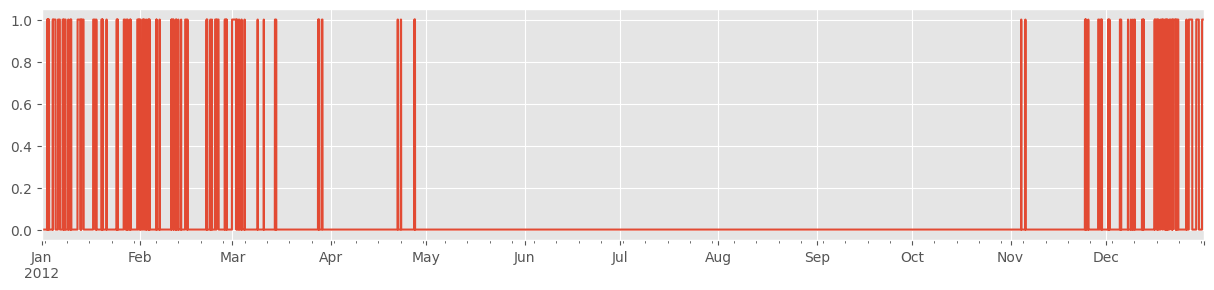

In [56]:
is_snowing.plot()

<Axes: >

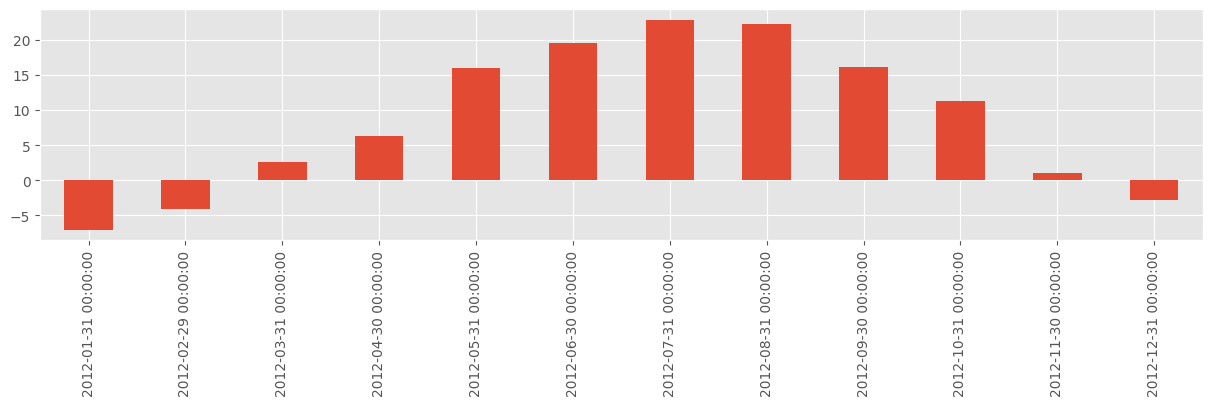

In [57]:
median_temperature.plot(kind="bar")

<Axes: >

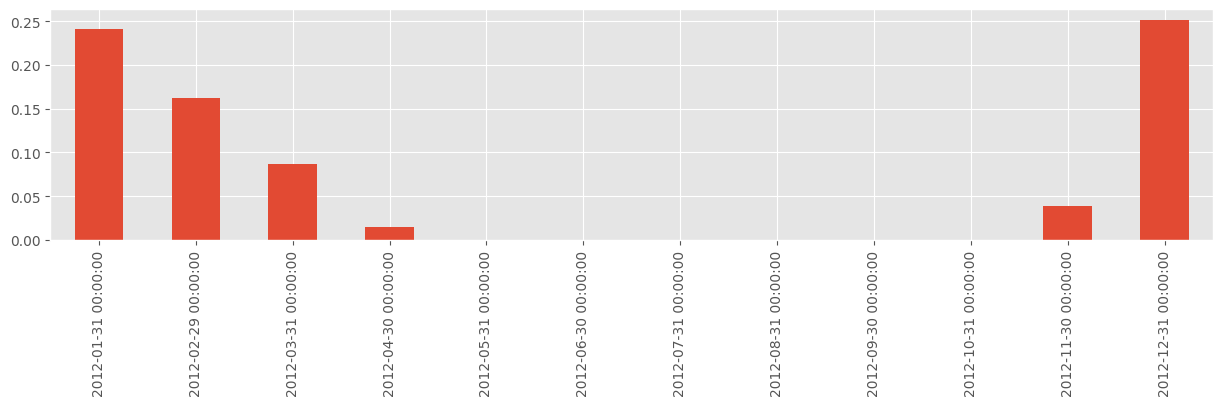

In [58]:
snow_frequency.plot(kind="bar")

array([<Axes: title={'center': 'temperature'}, xlabel='Date/Time'>,
       <Axes: title={'center': 'snowiness'}, xlabel='Date/Time'>],
      dtype=object)

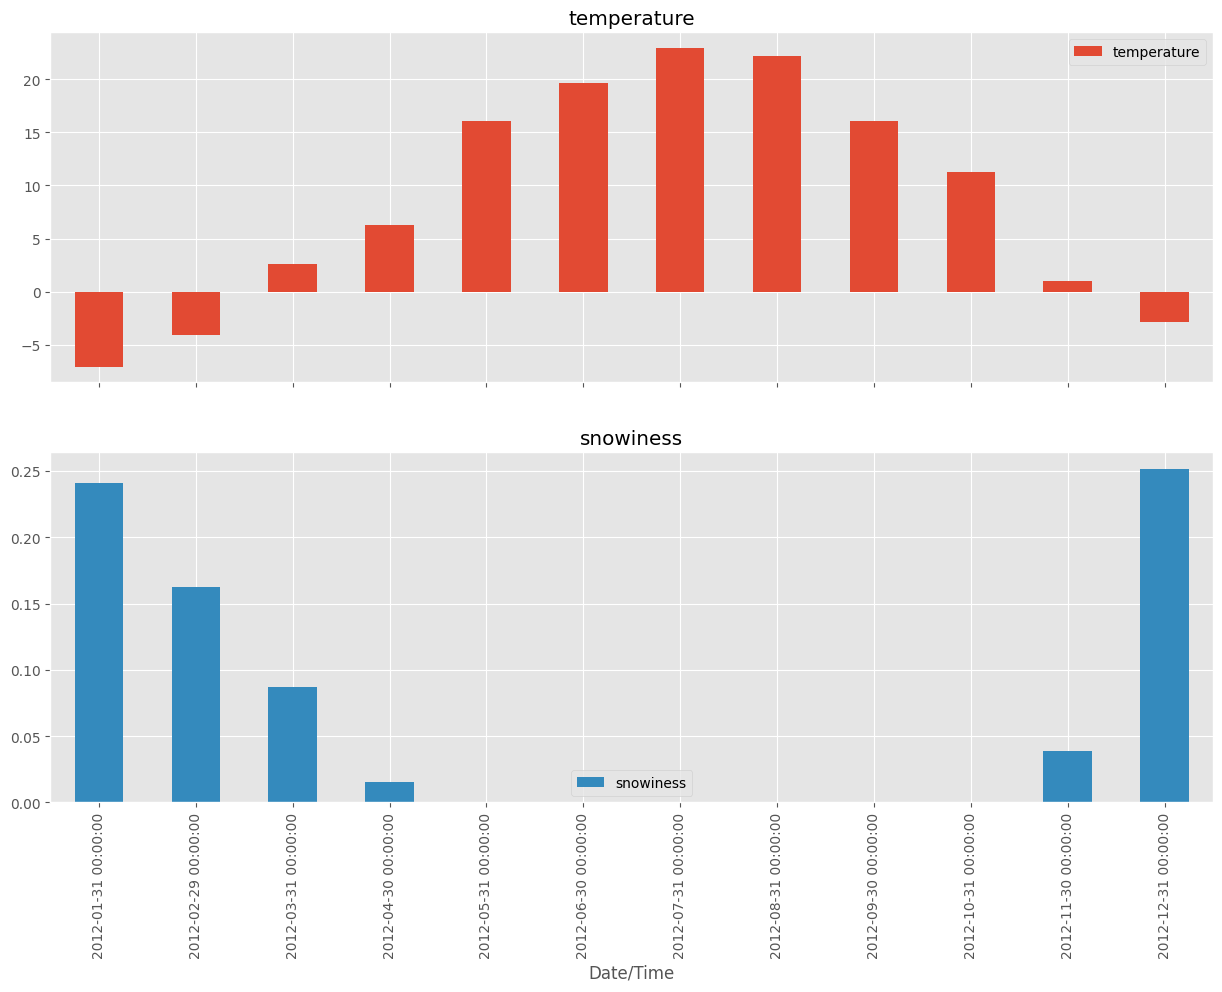

In [59]:
snow_and_temperature.plot(kind='bar', subplots=True, figsize=(15, 10))

In [60]:
node.land()

Stopping pandas-test-domain-6
